chat-gpt discussion [link](https://chatgpt.com/c/66fe9c2f-e8a0-8001-a307-57c29fb2eb4d), working email

5 levels of splitting [link](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb)

TODO the last and compare: Hierarcial clusterring and window clusterign within llama index (from 5 levels of clusterign), [link](https://docs.llamaindex.ai/en/stable/module_guides/loading/node_parsers/modules/)

hint for images and tables: when we are doing semantic search over our chunks, trying to match on embeddings from the table directly will be difficult. A common practice that developers do is to summarize the table after you've extracted it. Then get an embedding of that summary. If the summary embedding matches what you're looking for, then pass the raw table to your LLM.

In [1]:
%pip install -q langchain_community langchain llama_index sentence_transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

folder_path = os.path.dirname(os.getcwd()) + "/data/raw_ISO2007policies/"

standard_chunt_size = 128
standard_chunk_overlap = 0


## Load documents

#### Langchain readers

In [3]:
# from langchain_community.document_loaders import Docx2txtLoader

# def load_documents_langchain(folder_path):
#     """Function to load documents using langchain Docx2txtLoader"""
#     documents = []
#     for filename in os.listdir(folder_path):
#         if ".docx" in filename: # Docx2txtLoader doesn't work for pdf, md, etc
#             loader = Docx2txtLoader(os.path.join(folder_path, filename))
#             doc = loader.load()
#             documents.append(doc[0])
#     return documents

# # Load and chunk documents from the folder
# langchain_docs = load_documents_langchain(folder_path)

# langchain_docs[:2]

#### llama_index

In [4]:
from llama_index.core import SimpleDirectoryReader

llamaindex_docs = SimpleDirectoryReader(folder_path).load_data()

llamaindex_docs[:2]

[Document(id_='73ae89b7-ee56-4908-89ac-c7462fca10f9', embedding=None, metadata={'file_name': '[UnderDefense MAXI] - Access management policy.docx', 'file_path': '/home/bovchaliuk-v/projects/aqf-ai/data/raw_ISO2007policies/[UnderDefense MAXI] - Access management policy.docx', 'file_type': 'application/vnd.openxmlformats-officedocument.wordprocessingml.document', 'file_size': 368428, 'creation_date': '2024-08-17', 'last_modified_date': '2024-08-17'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text="Need Expert Assistance?\n\n\n\nNavigating the complexities of compliance can be challenging, especially for businesses with limited internal resources or expertise. \n\nExperience team at the right time\n\nPreparation of all compliance docs\n\nExpert guidance on 

## Splitters

#### langchain text splitter

In [5]:
# from langchain.text_splitter import RecursiveCharacterTextSplitter

# def langchain_text_plitter(docs):
#     langchain_splitter = RecursiveCharacterTextSplitter(chunk_size = standard_chunt_size, chunk_overlap=standard_chunk_overlap)
#     langchain_chunks = langchain_splitter.split_documents(docs)
#     return langchain_chunks

In [6]:
# lc_chunks = langchain_text_plitter(langchain_docs)

# for chunk_idx, lc_chunk in enumerate(lc_chunks):
#     if "Backup policy" in lc_chunk.metadata['source']:
#         print(f"------------- chunk index: {chunk_idx}")
#         print(lc_chunk.page_content)

In [7]:
# len(lc_chunks)

#### llama text splitter

In [8]:
from llama_index.core.node_parser import SentenceSplitter

def llamaindex_text_plitter(docs):
    llamaindex_splitter = SentenceSplitter(chunk_size=standard_chunt_size, chunk_overlap=standard_chunk_overlap)
    llamaindex_nodes = llamaindex_splitter.get_nodes_from_documents(docs, show_progress=False)
    return llamaindex_nodes

In [9]:
li_sentences = llamaindex_text_plitter(llamaindex_docs)

# for node_idx, li_node in enumerate(li_sentences):
#     if "Backup policy" in li_node.metadata['file_name']:
#         print(f"------------- chunk index: {node_idx}")
#         print(li_node.text)

> [!Warning]  
> llama index has fewer nodes/chunks then langchain  
> llama index chunks docs better (my subjective opinion)  

#### Cosine similarity splitter

In [10]:
from llama_index.core.node_parser import SentenceWindowNodeParser
from sentence_transformers import SentenceTransformer

# Define splitter and splitt docs
splitter = SentenceWindowNodeParser(window_size=1)
li_windows = splitter.build_window_nodes_from_documents(llamaindex_docs)

# Load a pretrained Sentence Transformer model
embed_model = SentenceTransformer("all-mpnet-base-v2")

/home/bovchaliuk-v/projects/aqf-ai/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/home/bovchaliuk-v/projects/aqf-ai/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
# Extract window texts to further calc similarities
li_window_texts = [node.metadata["window"] for node in li_windows]

# Calculate embeddings by calling model.encode()
li_window_embeddings = embed_model.encode(li_window_texts)
print(li_window_embeddings.shape)

(1268, 768)


In [12]:
similarities = []
for ind, emb in enumerate(li_window_embeddings):
    # elif ind == 1:  
    #     print(emb[:10])
    #     print(li_window_embeddings[ind][:10])
    #     print(li_window_embeddings[ind-1][:10])
    # Calculate the embedding similarities
    # FYI: first value describe similarity between first and last nodes (they are in a different files)
    similarities.append(embed_model.similarity(emb, li_window_embeddings[ind-1]))

# Convert list of torch ndarrays to list of floats
similarities_lst = [t.item() for t in similarities]

In [13]:
change_file_indx = []
for ind, node in enumerate(li_windows):
    if ind == 0: continue
    fname = node.source_node.metadata["file_name"]
    fname_prev_node = li_windows[ind-1].source_node.metadata["file_name"]
    if fname != fname_prev_node:
        change_file_indx.append(ind)
        
        print(f"index: {ind}")
        print(f"previous node file name: {fname_prev_node}")
        print(f"this node file name: {fname}")

index: 48
previous node file name: [UnderDefense MAXI] - Access management policy.docx
this node file name: [UnderDefense MAXI] - Anti-virus_Anti-malware policy.docx
index: 88
previous node file name: [UnderDefense MAXI] - Anti-virus_Anti-malware policy.docx
this node file name: [UnderDefense MAXI] - Asset management policy.docx
index: 127
previous node file name: [UnderDefense MAXI] - Asset management policy.docx
this node file name: [UnderDefense MAXI] - Backup policy.docx
index: 161
previous node file name: [UnderDefense MAXI] - Backup policy.docx
this node file name: [UnderDefense MAXI] - Bring your own device policy.docx
index: 194
previous node file name: [UnderDefense MAXI] - Bring your own device policy.docx
this node file name: [UnderDefense MAXI] - Business continuity_Disaster recovery plan.docx
index: 392
previous node file name: [UnderDefense MAXI] - Business continuity_Disaster recovery plan.docx
this node file name: [UnderDefense MAXI] - Change management policy.docx
inde

In [14]:
# just to play with different bound of similarities 
for ind, node in enumerate(li_windows):
    if similarities_lst[ind] >= 0.97 and similarities_lst[ind] <= 1.0:
        print(f"Node_id {ind} and its similarity {similarities_lst[ind]}")
        print("previous node file name: ", li_windows[ind-1].source_node.metadata["file_name"])
        print("this node file name: ", node.source_node.metadata["file_name"])
        print("--------")
        print("previous node window_text:", li_windows[ind-1].metadata["window"])
        print("this node window_text:", node.metadata["window"])
        print("--------//----------------//--------")

Node_id 14 and its similarity 0.9722719192504883
previous node file name:  [UnderDefense MAXI] - Access management policy.docx
this node file name:  [UnderDefense MAXI] - Access management policy.docx
--------
previous node window_text: All <Company> information systems must be MFA protected where possible.

 All <Company> information systems must be accessible only through Corporate VPN when protection by MFA is impossible.

 All <Company> information systems must have a designated information owner responsible for managing and controlling access to the system. 


this node window_text: All <Company> information systems must be accessible only through Corporate VPN when protection by MFA is impossible.

 All <Company> information systems must have a designated information owner responsible for managing and controlling access to the system. 

 All <Company> information systems must have a designated system administrator. 
--------//----------------//--------
Node_id 49 and its similari

In [15]:
change_meaning_indx = []
for ind, node in enumerate(li_windows):
    if ind == 0: continue
    if similarities_lst[ind] < 0.9:
        change_meaning_indx.append(ind)

In [16]:
# Merge both (documents and meaning by similarity) indexes list  
ind_list = change_meaning_indx + change_file_indx
print("full number of splits:             ", len(ind_list))
# remove duplicates
ind_list = list(set(ind_list))

print("n of splits due to diff documnets: ", len(change_file_indx))
print("n of splits due to diff similarity:", len(change_meaning_indx))
print("after removing duplicates:         ", len(ind_list))

full number of splits:              1008
n of splits due to diff documnets:  24
n of splits due to diff similarity: 984
after removing duplicates:          984


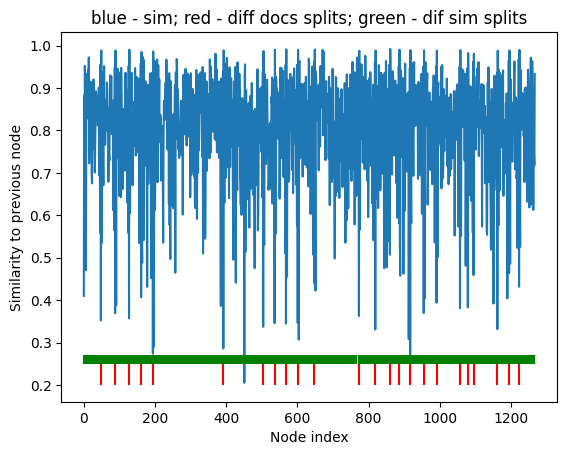

In [17]:
from matplotlib import pyplot as plt
plt.plot(range(0,len(similarities)), similarities_lst, )
plt.ylabel("Similarity to previous node")
plt.xlabel("Node index")
plt.title("blue - sim; red - diff docs splits; green - dif sim splits")
plt.vlines(change_file_indx, 0.2, 0.25, 'r')
plt.vlines(change_meaning_indx, 0.25, 0.27, 'g')

In [18]:
from llama_index.core.schema import TextNode, NodeRelationship, RelatedNodeInfo

# Merge similar nodes
li_simil_nodes = []

merged_node = TextNode(text="")
for ind, node in enumerate(li_windows):
    # within 0 ind we will create merged_node in next if since 
    #   ind_list has 0 chance to be in ind_list, so if the next first node
    #   differs then we have to append the final list and proceed
    if ind == 1 and ind in ind_list:
        li_simil_nodes.append(merged_node)
        merged_node = TextNode(text="")
    
    # if not is index split list then merge with previously merged nodes
    if ind not in ind_list:
        merged_node = TextNode(text=" ".join([merged_node.text, node.text]), 
                             id_=node.id_,
                             extra_info=node.extra_info,
                             excluded_embed_metadata_keys=node.excluded_embed_metadata_keys,
                             excluded_llm_metadata_keys=node.excluded_llm_metadata_keys,
                             relationships=node.relationships
                             )
    # if index split in the list then check merged_node.text
    else:
        if merged_node.text == "": # if nothing was merged then add node
            li_simil_nodes.append(node)
        else: # if there are something in merged than add this node text and add to final list
            merged_node = TextNode(text=" ".join([merged_node.text, node.text]), 
                        id_=node.id_,
                        extra_info=node.extra_info,
                        excluded_embed_metadata_keys=node.excluded_embed_metadata_keys,
                        excluded_llm_metadata_keys=node.excluded_llm_metadata_keys,
                        relationships=node.relationships
                        )
            li_simil_nodes.append(merged_node)
            merged_node = TextNode(text="")
    

In [19]:
print(f'lenghts of original and merged nodes: {len(li_windows)} and {len(li_simil_nodes)}')

lenghts of original and merged nodes: 1268 and 985


In [20]:
ind = 0
print(f'original node file name: ', li_windows[0].source_node.metadata['file_name'])
print(f'merge node file name:    ', li_simil_nodes[0].source_node.metadata['file_name'])

original node file name:  [UnderDefense MAXI] - Access management policy.docx
merge node file name:     [UnderDefense MAXI] - Access management policy.docx


In [21]:
li_windows[0].text

'Need Expert Assistance?\n\n\n\n'

In [22]:
li_windows[5].text

'CAUTION: the thumbnail is not intended to summarize the difference and is not a substitute for reading the full text.\n\n\n\n\n'

In [23]:
li_simil_nodes[0].text

' Need Expert Assistance?\n\n\n\n'

#### LLM semantic splitter

In [24]:
from llama_index.core.node_parser import SemanticSplitterNodeParser
from llama_index.embeddings.openai import OpenAIEmbedding
import json

embed_model = OpenAIEmbedding()
splitter = SemanticSplitterNodeParser(buffer_size=1, breakpoint_percentile_threshold=95, embed_model=embed_model)

# li_seman_nodes = splitter.build_semantic_nodes_from_documents(llamaindex_docs)
# with open('llamaindex_semantic_splitter_results_with_OpenAI.jsonl', 'w') as f:
#     for node in li_seman_nodes:
#         f.write(f"{json.dumps(node.to_dict())}\n")
# # fyi: tooks 37 sec for raw_ISO2007policies, openAI пише що було 45000 токенів, з'їло 0.01 центи (щось якось дуже мало)

In [25]:
li_seman_nodes = [] # read locally stored processed data by OpenAI

with open("llamaindex_semantic_splitter_results_with_OpenAI.jsonl", 'r', encoding='utf-8') as f:
    for line in f:
       json_dict = json.loads(line) 
       li_seman_nodes.append(TextNode(
           text = json_dict["text"],
           id_ = json_dict["id_"],
           metadata = json_dict["metadata"],
           excluded_embed_metadata_keys = json_dict["excluded_embed_metadata_keys"],
           excluded_llm_metadata_keys = json_dict["excluded_llm_metadata_keys"],
           relationships = json_dict["relationships"],
       ))

#### final list of nodes

In [26]:
print(len(li_sentences))
print(len(li_simil_nodes))
print(len(li_seman_nodes))

496
985
98


## Topic detection

### Kmeans/LDA(BOW+scikitLDA)/LDA(gensim)

What we have after splitters:  
li_sentences   -- 496 nodes  
li_simil_nodes -- 985 nodes  
li_seman_nodes -- 98 nodes  

є два підходи:
- кластиризувати ноди (ллама термінологія для чанків тексту) в середині файлу і тоді вибирати суміжні топіки/класи і об'єднувати ноди. чи треба після цього порівнювати топіки між файлами? і чи об'єднувати тексти між файлами? 
- збирати всі ноди до купи (з усіх файлів), кластиризувати і тоді з'єднувати ноди з тим самим класом і файлом (? і чи треба розділяти по файлово після цього? ім'я файлу є в метаданих і буде в векторній БД...)

Так як в мене вже є ноди по всім файлам то йду другим шляхом. + Назви файлів є в метаданих нод (ім'я файлу якому він відповідає) 

In [27]:
from matplotlib import pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [28]:
llamaindex_nodes_txt = [x.text for x in li_sentences]
topic_range = range(2, 100)

#### KMeans + Tfidf

1. Calculate/define most optimal number of clusters
2. Cluster chunks and update nodes with a cluster number

In [29]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize and cluster using TF-IDF method
vectorizer = TfidfVectorizer(stop_words='english')
nodes_tfidf_vectorized = vectorizer.fit_transform(llamaindex_nodes_txt)

# Loop to calc metrics to find out best number of clusters
ch_scores, db_scores = [], []
for num_clusters in topic_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(nodes_tfidf_vectorized)
    labels = kmeans.labels_
    ch_scores += [calinski_harabasz_score(nodes_tfidf_vectorized.toarray(), labels)]
    db_scores += [davies_bouldin_score(nodes_tfidf_vectorized.toarray(), labels)]


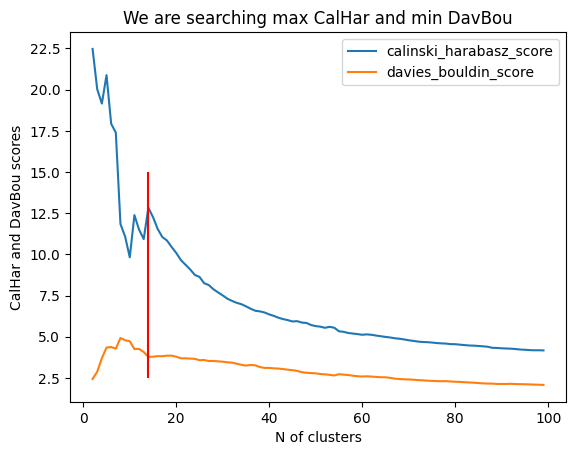

In [30]:
# Plot CalHar and DavBou scores
plt.plot(topic_range, ch_scores, label='calinski_harabasz_score')
plt.plot(topic_range, db_scores, label='davies_bouldin_score')
plt.vlines(14, 2.5, 15, 'r')
plt.xlabel("N of clusters")
plt.ylabel("CalHar and DavBou scores")
plt.title("We are searching max CalHar and min DavBou")
plt.legend()

Automatization to find a number of clusters automatically seems unreal. 

Let's set it manually equeal to 14.

In [125]:
# KMeans 
num_clusters = 14
random_state = 42

# # Vectorize and cluster using TF-IDF method
# vectorizer = TfidfVectorizer(stop_words='english')
# nodes_tfidf_vectorized = vectorizer.fit_transform(llamaindex_nodes_txt)
# nodes_tfidf_vectorized alredy done above
kmeans = KMeans(n_clusters=num_clusters, random_state=random_state)
kmeans.fit(nodes_tfidf_vectorized)

# Get cluster topic_id based on labels
text_topic_id = kmeans.labels_

# Add cluster_id into nodes
for i, node in enumerate(llamaindex_nodes_txt):
    li_sentences[i].extra_info["cluster_id1"] = int(text_topic_id[i])

In [32]:
cluster_id = 10
text_of_node_id = [node.text for node in li_sentences if node.extra_info["cluster_id1"] == cluster_id]

text_of_node_id

['Version Control Table\n\nVersion\n\nDate\n\nAuthor\n\nDescription\n\n1.0\n\n<Date>\n\n<Author>\n\nIssued\n\n1.0\n\n<Date>\n\n<Author>\n\nReviewed\n\n1.0\n\n<Date>\n\n<Author>\n\nApproved\n\n1.0\n\n<Date>\n\n<Author>\n\nGranted “FINAL” status\n\n\n\nDate of Next Revision\n\n<date>',
 '<Your Company Logo>\n\nAnti-Virus/Anti-Malware Policy\n\n\nVersion Control Table\n\nVersion\n\nDate\n\nAuthor\n\nDescription\n\n1.0\n\n<Date>\n\n<Author>\n\nIssued\n\n1.0\n\n<Date>\n\n<Author>\n\nUpdated\n\n1.0\n\n<Date>\n\n<Author>\n\nApproved\n\n1.0\n\n<Date>\n\n<Author>\n\nGranted “FINAL” status',
 '<Your Company Logo>\n\nAsset Management Policy\n\n\nVersion Control Table\n\nVersion\n\nDate\n\nAuthor\n\nDescription\n\n1.0\n\n<Date>\n\n<Author>\n\nIssued\n\n1.0\n\n<Date>\n\n<Author>\n\nReviewed\n\n1.0\n\n<Date>\n\n<Author>\n\nApproved\n\n1.0\n\n<Date>\n\n<Author>\n\nGranted “FINAL” status\n\n\n\nDate of Next Revision\n\n<date>',
 '<Your Company Logo>\n\nBackup Policy\n\n\n\n\nVersion Control Table\n\nV

#### LDA + CountVectorizer
- scikit learn
- why not TF-IDF vectorizer? read below:

Representation of Documents:
- CountVectorizer: Creates a document-term matrix based on the raw counts of words. Each entry represents how many times a word appears in a document. This representation retains the frequency of words, which is important for LDA since it is a probabilistic model that assumes words are generated based on a multinomial distribution.
- TfidfVectorizer: Computes the Term Frequency-Inverse Document Frequency (TF-IDF) scores, which normalize the word counts based on their frequency across all documents. This means that common words (stop words) are down-weighted, and rare words receive more weight. LDA may not perform as well with TF-IDF because it relies on frequency counts rather than normalized scores.

Model Assumptions:
- LDA assumes that documents are mixtures of topics and that topics are distributions over words. The model works best when the input reflects the raw counts of how many times words appear in documents, as it tries to infer the latent topics from the data distribution.
- TF-IDF transforms the data in a way that can obscure these distributions, potentially leading LDA to infer topics that do not align with the actual distributions of words in documents.

Interpretability of Topics:
- With CountVectorizer, the resulting topics may be more interpretable, as they will reflect the actual word usage in documents.
- Using TfidfVectorizer, the topics may become less interpretable because the model focuses on rarer terms, which might not represent the main themes of the documents.

In [33]:
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score


# Vectorize the documents
vectorizer = CountVectorizer(stop_words='english')
nodes_bow_vectorized = vectorizer.fit_transform(llamaindex_nodes_txt)

# Try different numbers of topics and evaluate perplexity
perplexities, log_likelihoods = [], []
ch_scores2, db_scores2 = [], []
for n_topics in topic_range:
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=random_state)
    lda.fit(nodes_bow_vectorized)
    
    perplexities.append(lda.perplexity(nodes_bow_vectorized))
    log_likelihoods.append(lda.score(nodes_bow_vectorized))
    
    # labels = lda.labels_
    # ch_scores2.append(calinski_harabasz_score(nodes_bow_vectorized.toarray(), labels))
    # db_scores2.append(davies_bouldin_score(nodes_bow_vectorized.toarray(), labels))
    

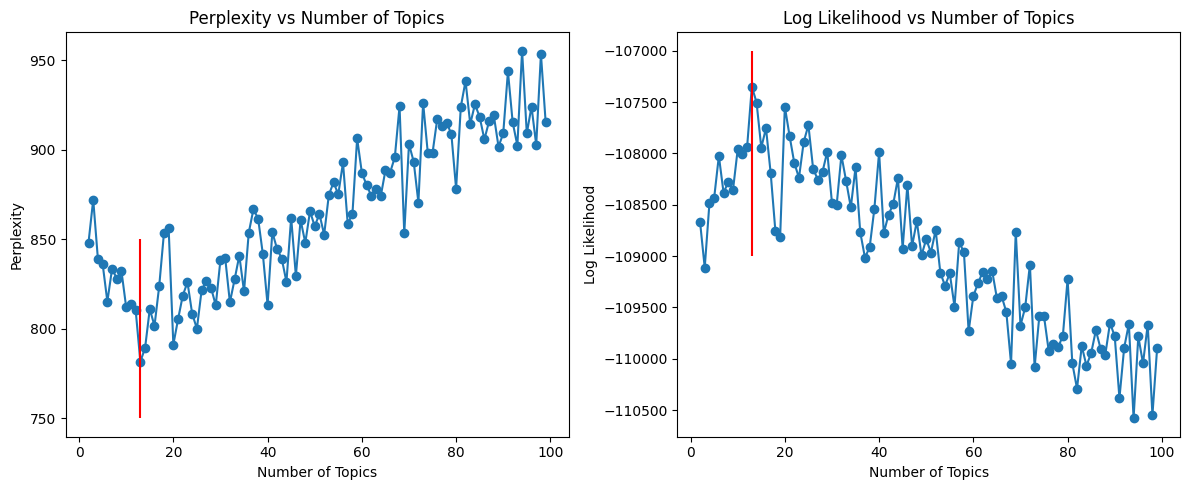

In [34]:
n_cluster_line = 13

# Plot Perplexity and Log Likelihood
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(topic_range, perplexities, marker='o')
plt.vlines(n_cluster_line,750,850,colors='r')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Perplexity vs Number of Topics')

plt.subplot(1, 2, 2)
plt.plot(topic_range, log_likelihoods, marker='o')
plt.vlines(n_cluster_line,-109000,-107000,colors='r')
plt.xlabel('Number of Topics')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood vs Number of Topics')

plt.tight_layout()
plt.show()

In [35]:
li_sentences[0].text[0:20]

'Need Expert Assistan'

In [37]:
llamaindex_nodes_txt[0][:20]

'Need Expert Assistan'

In [124]:
lda = LatentDirichletAllocation(n_components=n_cluster_line, random_state=random_state)
nodes_bow_lda_tranf = lda.fit_transform(nodes_bow_vectorized)

# Assign the most probable topic for each document
assigned_topics = nodes_bow_lda_tranf.argmax(axis=1)

# Add cluster_id into nodes
for i, doc in enumerate(nodes_bow_vectorized):
    # print(f"\t\tFirst 20 char of origin: {llamaindex_nodes[i].text[:20]} \n\
    #             Should be the same     : {llamaindex_nodes_txt[i][:20]}")
    # print(f"Document {i} is assigned to Topic {assigned_topics[i]}")
    li_sentences[i].extra_info["cluster_id2"] = int(assigned_topics[i])

IndexError: index 10 is out of bounds for axis 0 with size 10

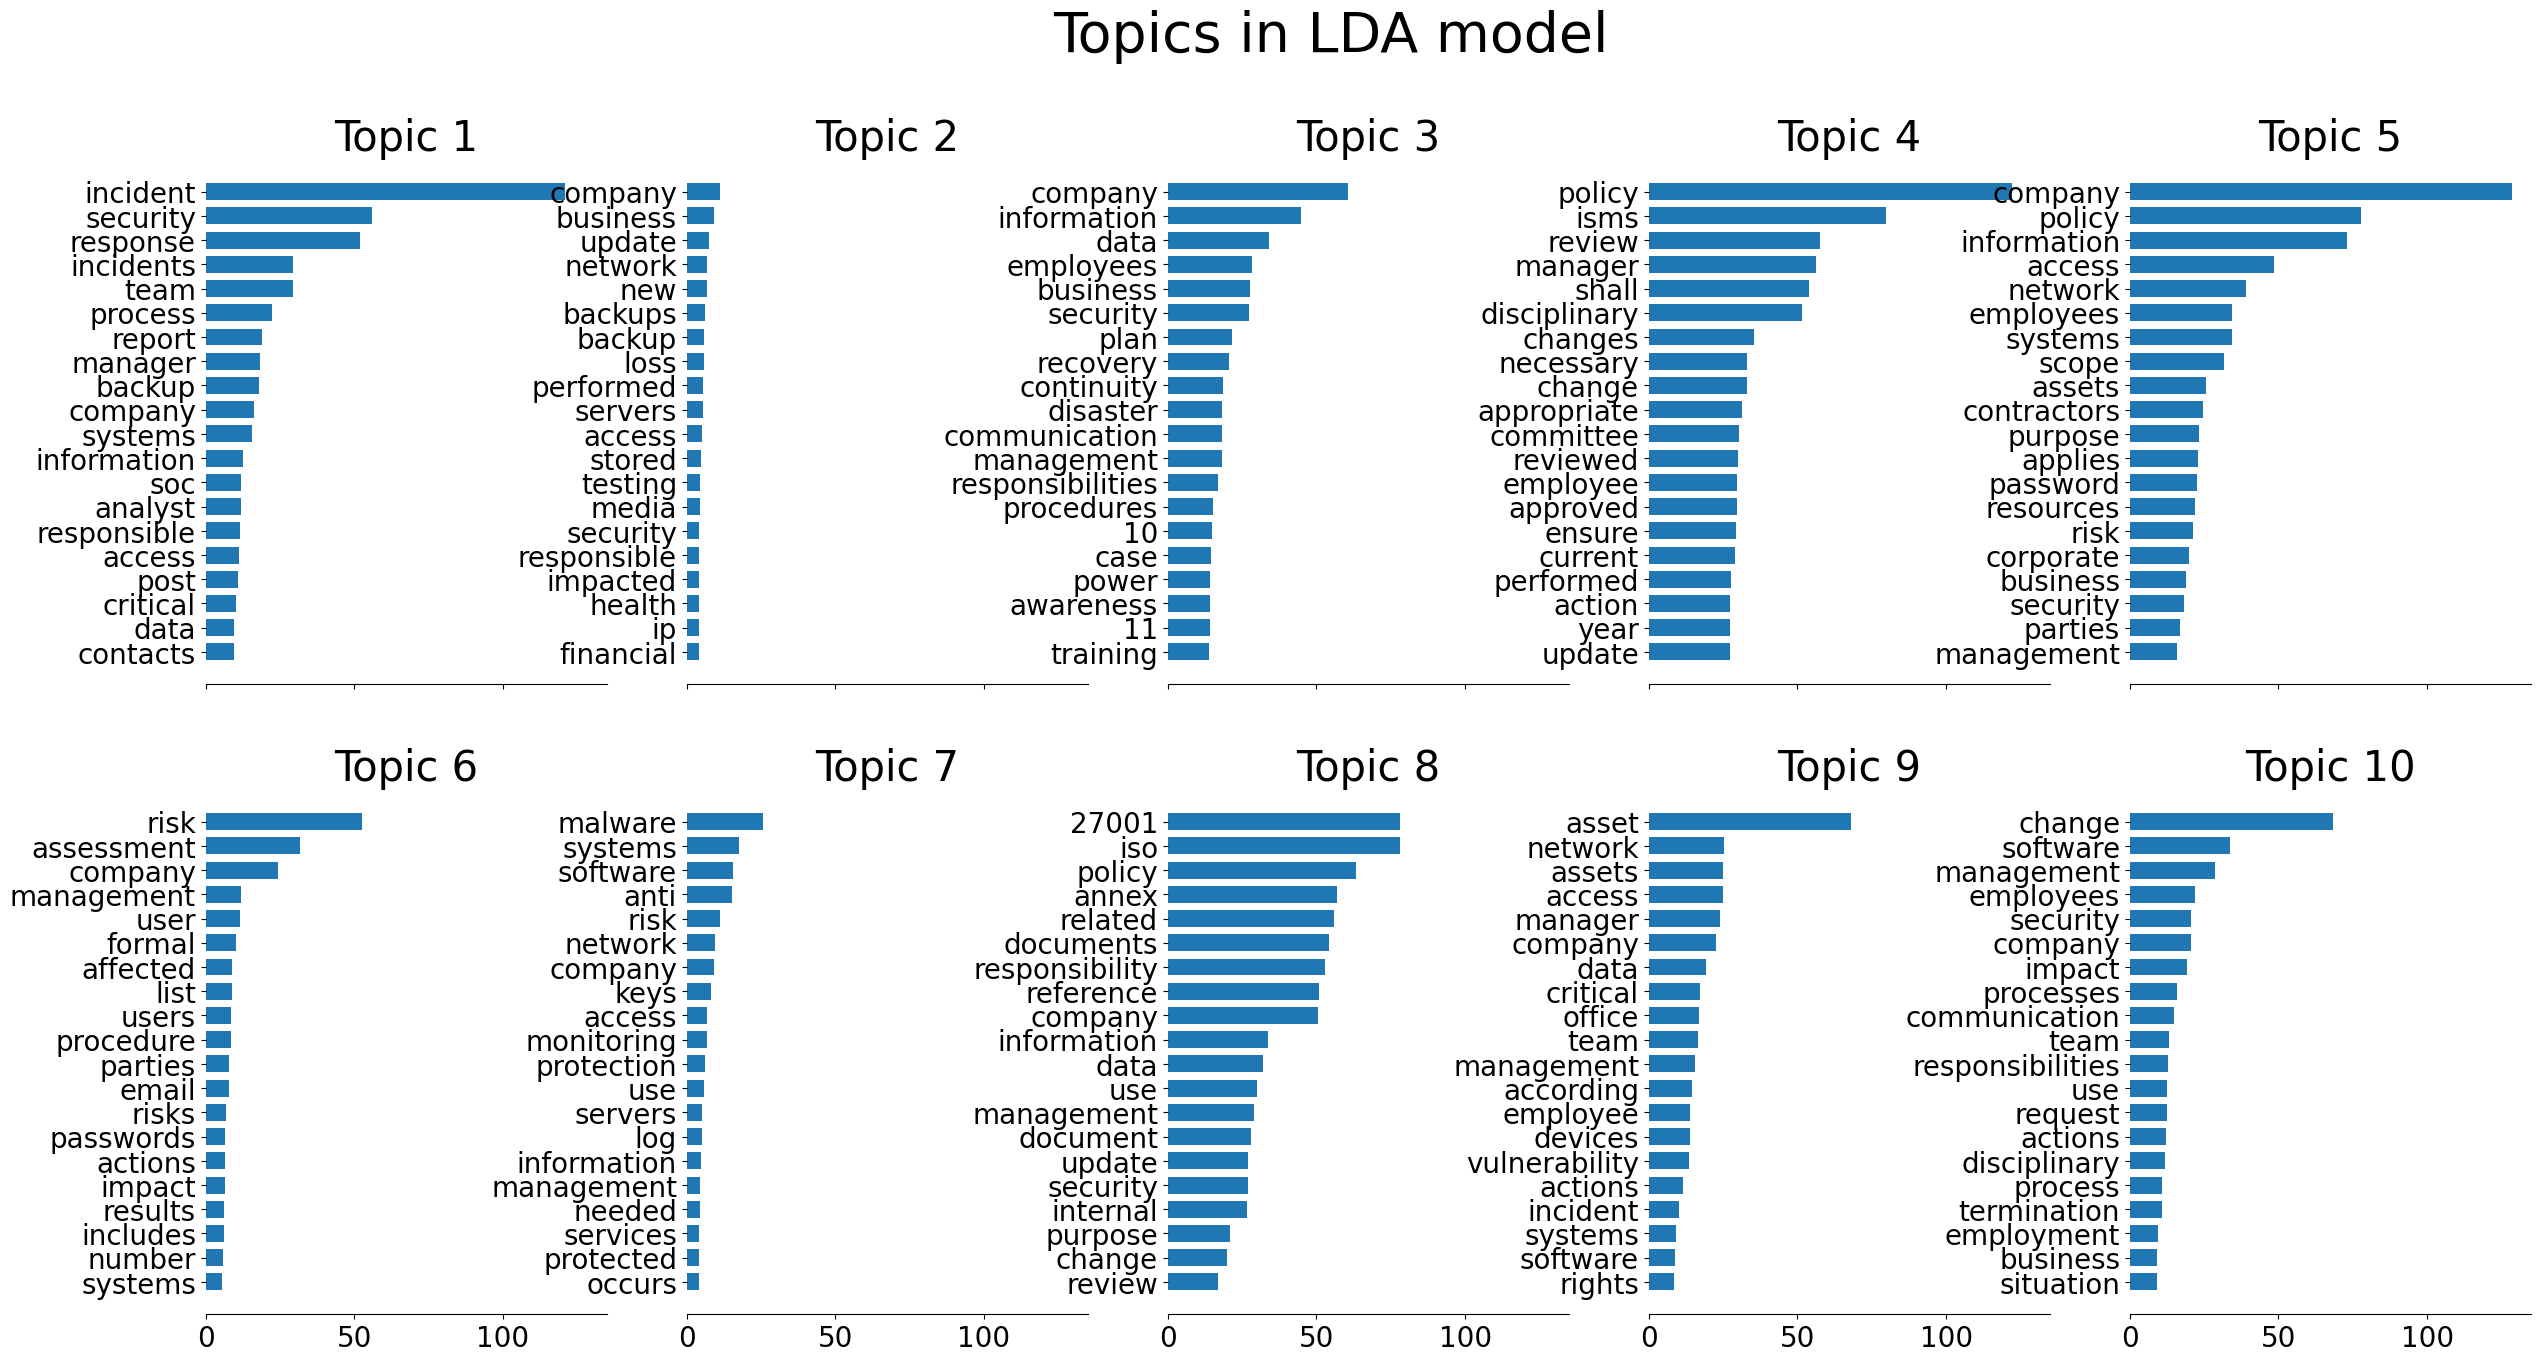

In [39]:
# Plot top words for BOW+LDA model
tf_feature_names = vectorizer.get_feature_names_out()
n_top_words = 20

plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

#### LDA gensim

In [40]:
import gensim
from gensim import corpora
from nltk.corpus import stopwords
import string
from gensim.models import CoherenceModel

# Step 1: Preprocess the text (Tokenization, Stop Word Removal, and Punctuation Removal)
# Define stop words and punctuation
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

# Tokenize and remove stop words and punctuation
def preprocess(doc):
    tokens = doc.lower().split()  # Tokenize and lower case
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations]
    return tokens

# Apply preprocessing to all documents
processed_docs = [preprocess(doc) for doc in llamaindex_nodes_txt]

# Step 2:
# Create a dictionary and corpus for gensim
id2word = corpora.Dictionary(processed_docs)
corpus = [id2word.doc2bow(text) for text in processed_docs]

# Compute coherence scores for different numbers of topics
coherence_scores = []
for n_topics in topic_range:
    lda_gensim = gensim.models.LdaModel(corpus, num_topics=n_topics, id2word=id2word, passes=10)
    coherence_model_lda = CoherenceModel(model=lda_gensim, texts=processed_docs, dictionary=id2word, coherence='c_v')
    coherence_scores.append(coherence_model_lda.get_coherence())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

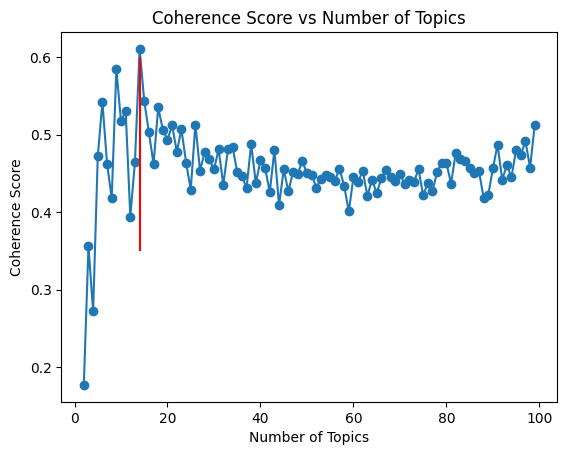

In [42]:
# Plot coherence scores
plt.plot(topic_range, coherence_scores, marker='o')
plt.vlines(14, 0.35, 0.6, 'r')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs Number of Topics')
plt.show()

In [43]:
lda_gensim = gensim.models.LdaModel(corpus, num_topics=14, id2word=id2word, passes=10)

n_top_words = 20
topics = lda_gensim.show_topics(num_topics=12, num_words=n_top_words, formatted=False)

# Assign the most probable topic for each document
assigned_topics = lda_gensim.get_topics()

# Displaying the topics and top words
for idx, topic in topics:
    print(f"Topic {idx}:")
    words = [word for word, _ in topic]
    print("Top words:", ", ".join(words))

# # Alternatively, you can format the topics for easier readability
# for idx, topic in topics:
#     print(f"\nTopic {idx}:")
#     for word, weight in topic:
#         print(f"{word}: {weight:.4f}")

Topic 5:
Top words: <company>, incident, hr, communication, business, team, response, must, <name>, security, employees, incidents, contractors, continuity, information, responsible, case, employment, termination, isms
Topic 13:
Top words: affected, incident, systems, data, {insert, company, email, parties, 1., must, formal, system, includes, ir, low;, backups, recovery, recommendations, risk, impact
Topic 0:
Top words: iso, 27001, annex, responsibility, data, information, isms, policy, use, manager, policy., <company>, reference, everyone, make, sure, management, aware, maintain, password
Topic 4:
Top words: policy, isms, disciplinary, shall, manager, management, actions, update, every, performed, employees, necessary, employee’s, ensure, take, determine, appropriate, owner, year, earlier
Topic 10:
Top words: change, impact, employees, recovery, team, change:, disaster, incident, via, communication, email, critical, request, provide, 1, <company>, reason, description, use, necessary
T

In [122]:
# Add cluster_id into nodes
for i, unseen_corp in enumerate(corpus):
    topics_probs = lda_gensim[unseen_corp]
    # Find the tuple with the maximum float
    most_prob_topic_tuple = max(topics_probs, key=lambda x: x[1])
    topic_numb = most_prob_topic_tuple[0]
    
    li_sentences[i].extra_info["cluster_id3"] = int(topic_numb)

In [128]:
li_sentences[0].extra_info

{'file_name': '[UnderDefense MAXI] - Access management policy.docx',
 'file_path': '/home/bovchaliuk-v/projects/aqf-ai/data/raw_ISO2007policies/[UnderDefense MAXI] - Access management policy.docx',
 'file_type': 'application/vnd.openxmlformats-officedocument.wordprocessingml.document',
 'file_size': 368428,
 'creation_date': '2024-08-17',
 'last_modified_date': '2024-08-17',
 'cluster_id1': 9,
 'cluster_id2': 11,
 'cluster_id3': 11}

#### Save results

In [127]:
li_sentences
with open('li_sentences_KMeans14_scikitLDA13_gensimLDA14.jsonl', 'w') as f:
    for node in li_sentences:
        f.write(f"{json.dumps(node.to_dict())}\n")

## What was done

1. Two loaders: llamaindex and langchain. Llamaindex works better on my subjective opipion since it have more nodes/chunks within the same standard_chunt_size param value.
2. Created 4 splitters, here is a confirmation that llama index Sentence splitter splits docs into more nodes/chunks rather than langechain with the same standard_chunt_size. Cosine similarity splitter similar to one described [here](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb) (Level 4: Semantic Splitting), and semantic splitter using OpenAI embeddings model similarly to (Level 5: Agentic Chunking, previous link) based on llamachain realization [link](https://docs.llamaindex.ai/en/stable/examples/node_parsers/semantic_chunking/). Semantic splitter results save into `llamaindex_semantic_splitter_results_with_OpenAI.jsonl` (there is also code to load data from this file as it just returned from SemanticSplitter method).
3. Only `li_sentences` (second splitter, simple llamaindex Sentence splitter) where processed with clusterization (topic detection). Three clustering approaches: TF-IDF+KMeans, BOW+scikitLDA, gensim LDA. KMeans idenfied 14 topics, BOW+LDA 13 topics, and gensim LDA 14 topic (nodes between KMeans and gensimLDA topics differ). Results saved in  `li_sentences_KMeans14_scikitLDA13_gensimLDA14.jsonl`  
Defined clusters/topics added to `li_sentences` inside extra_info. Check `li_sentences[0].extra_info`: cluster_id1=Kmeans; cluster_id2=BOW+LDA; cluster_id3=gensimLDA

**Next steps**
- move splitters into separate python notebook and check RAG quality using ragas or something else
- add preprocesors to Expande Contractions, Lematization, remove stop_words and punctuation (done within TF-IDF/BOW vectorization), etc.
- compare topic nodes within different approaches
- call LLM based on most frequent words within topics to somethow describe/name these topics